# Google Colab Setup

Please run the code below to mount drive if you are running on colab.

Please ignore if you are running on your local machine.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/MiniGPT/

/content/drive/MyDrive/MiniGPT


# Language Modeling and Transformers

The project will consist of two broad parts.

1. **Baseline Generative Language Model**: We will train a simple Bigram language model on the text data. We will use this model to generate a mini story.
2. **Implementing Mini GPT**: We will implement a mini version of the GPT model layer by layer and attempt to train it on the text data. You will then load pretrained weights provided and generate a mini story.

## Some general instructions

1. Please keep the name of layers consistent with what is requested in the `model.py` file for each layer, this helps us test in each function independently.
2. Please check to see if the bias is to be set to false or true for all linear layers (it is mentioned in the doc string)
3. As a general rule please read the docstring well, it contains information you will need to write the code.
4. All configs are defined in `config.py` for the first part while you are writing the code do not change the values in the config file since we use them to test. Once you have passed all the tests please feel free to vary the parameter as you please.
5. You will need to fill in the `train.py` and run it to train the model. If you are running into memory issues please feel free to change the `batch_size` in the `config.py` file. If you are working on Colab please make sure to use the GPU runtime and feel free to copy over the training code to the notebook.

In [ ]:
!pip install numpy torch tiktoken wandb einops # Install all required packages

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import torch
import tiktoken

In [ ]:
from model import BigramLanguageModel, SingleHeadAttention, MultiHeadAttention, FeedForwardLayer, LayerNorm, TransformerLayer, MiniGPT
from config import BigramConfig, MiniGPTConfig
import tests

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
print(device)

cuda


In [ ]:
path_to_bigram_tester = "./pretrained_models/bigram_tester.pt" # Load the bigram model with name bigram_tester.pt
path_to_gpt_tester = "./pretrained_models/minigpt_tester.pt" # Load the gpt model with name minigpt_tester.pt

##  Bigram Language Model (10 points)

A bigram language model is a type of probabilistic language model that predicts a word given the previous word in the sequence. The model is trained on a text corpus and learns the probability of a word given the previous word.



### Implement the Bigram model (5 points)

Please complete the `BigramLanguageModel` class in model.py. We will model a Bigram language model using a simple MLP with one hidden layer. The model will take in the previous word index and output the logits over the vocabulary for the next word.

In [ ]:
# Test implementation for Bigram Language Model
model = BigramLanguageModel(BigramConfig)
tests.check_bigram(model,path_to_bigram_tester, device)

'TEST CASE PASSED!!!'

### Training the Bigram Language Model (2.5 points)

Complete the code in `train.py` to train the Bigram language model on the text data. Please provide plots for both the training and validation in the cell below.

Some notes on the training process:

1. You should be able to train the model slowly on your local machine.
2. Training it on Colab will help with speed.
3.  <span style="color:red">To get full points for this section it is sufficient to show that the loss is decreasing over time</span>. You should see it saturate to a value close to around 5-6 but as long as you see it decreasing then saturating you should be good.
4. Please log the loss curves either on wandb, tensorboard or any other logger of your choice and please attach them below.

In [ ]:
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import os

import torch.optim as optim
import torch.nn.utils
from torch.utils.data import DataLoader
from einops import rearrange
import wandb

from model import BigramLanguageModel, MiniGPT
from dataset import TinyStoriesDataset
from config import BigramConfig, MiniGPTConfig


MODEL = "bigram"  # bigram or minigpt

if MODEL == "bigram":
    config = BigramConfig
    model = BigramLanguageModel(config)
elif MODEL == "minigpt":
    config = MiniGPTConfig
    model = MiniGPT(config)
else:
    raise ValueError("Invalid model name")


# Initialize wandb if you want to use it
if config.to_log:
    wandb.init(project="dl2_proj3")


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


train_dataset = TinyStoriesDataset(
    config.path_to_data,
    mode="train",
    context_length=config.context_length,
)
eval_dataset = TinyStoriesDataset(
    config.path_to_data, mode="test", context_length=config.context_length
)

train_dataloader = DataLoader(
    train_dataset, batch_size=config.batch_size, pin_memory=True
)
eval_dataloader = DataLoader(
    eval_dataset, batch_size=config.batch_size, pin_memory=True
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("number of trainable parameters: %.2fM" % (count_parameters(model) / 1e6,))


if not Path.exists(config.save_path):
    Path.mkdir(MiniGPTConfig.save_path, parents=True, exist_ok=True)


### ==================== START OF YOUR CODE ==================== ###
"""
You are required to implement the training loop for the model.

Please keep the following in mind:
- You will need to define an appropriate loss function for the model.
- You will need to define an optimizer for the model.
- You are required to log the loss (either on wandb or any other logger you prefer) every `config.log_interval` iterations.
- It is recommended that you save the model weights every `config.save_iterations` iterations you can also just save the model with the best training loss.

Please check the config file to see the different configurations you can set for the model.
NOTE :
The MiniGPT config has params that you do not need to use, these were added to scale the model but are
not a required part of the assignment.
Feel free to experiment with the parameters and I would be happy to talk to you about them if interested :)
"""

def save_checkpoint(save_path, model, optimizer, dmconfig):
    save_ckpt = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'dmconfig': dmconfig
    }
    torch.save(save_ckpt, save_path)


optimizer = optim.Adam(model.parameters(), lr=1e-4)

def train_and_test(train_dataloader,eval_dataloader, model, optimizer,device,test_length=1000):
    model = model.to(device)
    model.train()
    criterion = nn.CrossEntropyLoss()
    best_tr_loss = 1e10
    for i,(x,y) in enumerate(tqdm(train_dataloader,leave = True, desc = 'training')):
        x,y = x.to(device),y.to(device)
        predicted_y = model(x)
        y = y.squeeze(1)
        loss = criterion(predicted_y,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i%config.log_interval==0:
          wandb.log({"training loss": loss})
        if i%config.save_iterations == 0:
          nth_check_point = str(i//config.save_iterations) + 'save_iterations_checkpoint.pth'
          save_best_path = os.path.join(config.save_path, nth_check_point)
          save_checkpoint(save_best_path, model, optimizer, config)
        if i%10000 == 0:
          test_loss = test(eval_dataloader=eval_dataloader,model=model,device=device,test_length=test_length)
          wandb.log({"test loss": test_loss})
        if i == len(train_dataloader)-1:
          break
    return

def test(eval_dataloader,model,device,test_length):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    test_loss = 0
    with torch.no_grad():
      for i,(x,y) in enumerate(eval_dataloader):
        x,y = x.to(device),y.to(device)
        predicted_y = model(x)
        y = y.squeeze(1)
        test_loss += criterion(predicted_y,y).item()
        predicted_y = None
        if i==test_length-1:
          break
      loss = test_loss/i
    return loss


train_and_test(train_dataloader=train_dataloader,eval_dataloader=eval_dataloader, model=model, optimizer=optimizer,device=device)

number of trainable parameters: 3.27M


training:   1%|          | 3119/473591 [00:13<34:34, 226.81it/s]


KeyboardInterrupt: 

### Train and Valid Plots


** Show the training and validation loss plots **

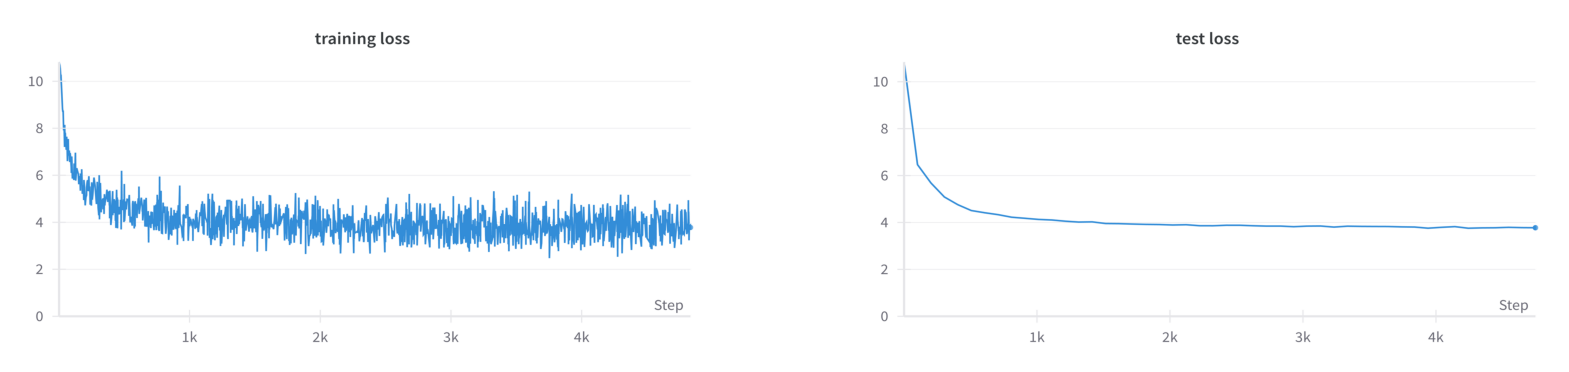

In [ ]:
from PIL import Image as PILImage
from IPython.display import display
import matplotlib.pyplot as plt

listOfImageNames = ['./Images/bigram_tr_loss.png', './Images/bigram_test_loss.png']

# Load and resize images
images = [PILImage.open(imageName).resize((1600, 800)) for imageName in listOfImageNames]  # Adjust the size as needed

# Display images side by side
fig, axes = plt.subplots(1, len(images), figsize=(20, 10))  # Adjust figsize as needed

for ax, img in zip(axes, images):
    ax.imshow(img)
    ax.axis('off')  # Hide axes

plt.show()

### Generation (2.5 points)

Complete the code in the `generate` method of the Bigram class and generate a mini story using the trained Bigram language model. The model will take in the previous word index and output the next word index.

Start with the following seed sentence:
    
    `"once upon a time"`
    

In [ ]:
import os
from model import BigramLanguageModel, MiniGPT
from config import BigramConfig, MiniGPTConfig


MODEL = "bigram"  # bigram or minigpt

if MODEL == "bigram":
    config = BigramConfig
    model = BigramLanguageModel(config)
elif MODEL == "minigpt":
    config = MiniGPTConfig
    model = MiniGPT(config)
else:
    raise ValueError("Invalid model name")

tokenizer = tiktoken.get_encoding("gpt2")

nth_check_point = str(47) + 'save_iterations_checkpoint.pth'
load_path = os.path.join(config.save_path, nth_check_point)
checkpoint = torch.load(load_path)

# Extract the configuration, model state dict, and optimizer state dict
dmconfig = checkpoint['dmconfig']
model_state_dict = checkpoint['model_state_dict']
optimizer_state_dict = checkpoint['optimizer_state_dict']

model = BigramLanguageModel(config)
# Load the model state dict
model.load_state_dict(model_state_dict)
model = model.to(device)

gen_sent = "Once upon a time"
gen_tokens = torch.tensor(tokenizer.encode(gen_sent))
print("Generating text starting with:", gen_tokens.shape)
gen_tokens = gen_tokens.to(device)
model.eval()
print(
    tokenizer.decode(
        model.generate(gen_tokens, max_new_tokens=200).squeeze().tolist()
    )
)

Generating text starting with: torch.Size([4])
Once upon a time, she was two friends saw a seed when he went to play more pepper. But why this- action means please." Theoppy up and made a good friends talked about?" Her helpful and not important. She walked under his red box didn't worry, there was cold. It was very surprised. He sang. Then, Lily tightly together.
They saw a time, Timmy told his hand and smiled and the fish Bear tried to the twins with her hand. Max. 
"No, my mommy had an idea. One day, Sam, "I see what was a little girl reindeer was a log down up. They say, Tom looked at each other. When her thanked her cereal sailed down and Ben, she went outside. He got very big, Lily decided to climb off to move time today. The car got bright instead. They kept running and said. A blue began. They played together all the blanket.
In the book to go, Timmy


### Observation and Analysis

Please answer the following questions.

1. What can we say about the generated text in terms of grammar and coherence?
2. What are the limitations of the Bigram language model?
3. If the model is scaled with more parameters do you expect the bigram model to get substantially better? Why or why not?

1. Grammar is bad. Generally there is no coherence in the generated text.
2. The Bigram model only considers the previous word when predicting the next word. This means it has a very short memory and cannot capture long-range dependencies in the text.
3. Scaling a Bigram language model with more parameters is unlikely to result in substantial improvements, since the fundamental limitation of the Bigram model is its reliance on only the previous word to predict the next word.

## Mini GPT (90 points)

We will not implement a decoder style transformer model like we discussed in lecture, which is a scaled down version of the [GPT model](https://cdn.openai.com/research-covers/language-unsupervised/language_understanding_paper.pdf).

All the model components follow directly from the original [Attention is All You Need](https://arxiv.org/abs/1706.03762) paper. The only difference is we will use prenormalization and learnt positional embeddings instead of fixed ones. But you will not need to worry about these details!

We will now implement each layer step by step checking if it is implemented correctly in the process. We will finally put together all our layers to get a fully fledged GPT model.

<span style="color:red">Later layers might depend on previous layers so please make sure to check the previous layers before moving on to the next one.</span>

### Single Head Causal Attention (20 points)

We will first implement the single head causal attention layer. This layer is the same as the scaled dot product attention layer but with a causal mask to prevent the model from looking into the future.

Recall that Each head has a Key, Query and Value Matrix and the scaled dot product attention is calculated as :

\begin{equation}
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
\end{equation}

where $d_k$ is the dimension of the key matrix.

Figure below from the original paper shows how the layer is to be implemented.

![image](./Images/Single_Head.png)

Image credits: [Attention is All You Need Paper](https://arxiv.org/abs/1706.03762)

Please complete the `SingleHeadAttention` class in `model.py`

In [ ]:
model = SingleHeadAttention(MiniGPTConfig.embed_dim, MiniGPTConfig.embed_dim//4, MiniGPTConfig.embed_dim//4) # configs are set as such for testing do not modify

tests.check_singleheadattention(model, path_to_gpt_tester, device)

'TEST CASE PASSED!!!'

### Multi Head Attention (10 points)

Now that we have a single head working, we will now scale this across multiple heads, remember that with multihead attention we compute perform head number of parallel attention operations. We then concatenate the outputs of these parallel attention operations and project them back to the desired dimension using an output linear layer.

Figure below from the original paper shows how the layer is to be implemented.

![image](./Images/MultiHead.png)

Image credits: [Attention is All You Need Paper](https://arxiv.org/abs/1706.03762)

Please complete the `MultiHeadAttention` class in `model.py` using the `SingleHeadAttention` class implemented earlier.

In [ ]:
model = MultiHeadAttention(MiniGPTConfig.embed_dim, MiniGPTConfig.num_heads)

tests.check_multiheadattention(model, path_to_gpt_tester, device)

'TEST CASE PASSED!!!'

### Feed Forward Layer (5 points)

As discussed in lecture, the attention layer is completely linear, in order to add some non-linearity we add a feed forward layer. The feed forward layer is a simple two layer MLP with a GeLU activation in between.

Please complete the `FeedForwardLayer` class in `model.py`

In [ ]:
model = FeedForwardLayer(MiniGPTConfig.embed_dim)

tests.check_feedforward(model, path_to_gpt_tester, device)

'TEST CASE PASSED!!!'

### LayerNorm (10 points)

We will now implement the layer normalization layer. Layernorm is used across the model to normalize the activations of the previous layer. Recall that the equation for layernorm is given as:

$$
\mathrm{LayerNorm}(x) = \frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}} \odot \gamma + \beta
$$

With the learnable parameters $\gamma$ and $\beta$.

Remember that unlike batchnorm we compute statistics across the feature dimension and not the batch dimension, hence we do not need to keep track of running averages.

Please complete the `LayerNorm` class in `model.py`

In [ ]:
model = LayerNorm(MiniGPTConfig.embed_dim)
tests.check_layernorm(model, path_to_gpt_tester, device)

'TEST CASE PASSED!!!'

### Transformer Layer (15 points)

We have now implemented all the components of the transformer layer. We will now put it all together to create a transformer layer. The transformer layer consists of a multi head attention layer, a feed forward layer and two layer norm layers.

Please use the following order for each component (Varies slightly from the original attention paper):
1. LayerNorm
2. MultiHeadAttention
3. LayerNorm
4. FeedForwardLayer

Remember that the transformer layer also has residual connections around each sublayer.

The below figure shows the structure of the transformer layer you are required to implement.

![prenorm_transformer](./Images/Prenorm.png)

Image Credit : [CogView](https://arxiv.org/pdf/2105.13290)

Implement the `TransformerLayer` class in `model.py`

In [ ]:
model =  TransformerLayer(MiniGPTConfig.embed_dim, MiniGPTConfig.num_heads)
tests.check_transformer(model, path_to_gpt_tester, device)

'TEST CASE PASSED!!!'

### Putting it all together : MiniGPT (15 points)

We are now ready to put all our layers together to build our own MiniGPT!

The MiniGPT model consists of an embedding layer, a positional encoding layer and a stack of transformer layers. The output of the transformer layer is passed through a linear layer (called head) to get the final output logits. Note that in our implementation we will use [weight tying](https://arxiv.org/abs/1608.05859) between the embedding layer and the final linear layer. This allows us to save on parameters and also helps in training.

Implement the `MiniGPT` class in `model.py`

In [ ]:
model = MiniGPT(MiniGPTConfig)
tests.check_miniGPT(model, path_to_gpt_tester, device)

'TEST CASE PASSED!!!'

### Attempt at training the model (5 points)

We will now attempt to train the model on the text data. We will use the same text data as before. Please scale down the model parameters in the config file to a smaller value to make training feasible.

Use the same training script we built for the Bigram model to train the MiniGPT model. If you implemented it correctly it should work just out of the box!

**NOTE** : We will not be able to train the model to completion in this assignment. Unfortunately, without access to a relatively powerful GPU, training a large enough model to see good generation is not feasible. However, you should be able to see the loss decreasing over time. <span style="color:red">To get full points for this section it is sufficient to show that the loss is decreasing over time</span>. You do not need to run this for more than 5000 iterations or 1 hour of training.

In [ ]:
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import os

import torch.optim as optim
import torch.nn.utils
from torch.utils.data import DataLoader
from einops import rearrange
import wandb

from model import BigramLanguageModel, MiniGPT
from dataset import TinyStoriesDataset
from config import BigramConfig, MiniGPTConfig


MODEL = "minigpt"  # bigram or minigpt

if MODEL == "bigram":
    config = BigramConfig
    model = BigramLanguageModel(config)
elif MODEL == "minigpt":
    config = MiniGPTConfig
    model = MiniGPT(config)
else:
    raise ValueError("Invalid model name")


# Initialize wandb if you want to use it
if config.to_log:
    wandb.init(project="dl2_proj3_minigpt")


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


train_dataset = TinyStoriesDataset(
    config.path_to_data,
    mode="train",
    context_length=config.context_length,
)
eval_dataset = TinyStoriesDataset(
    config.path_to_data, mode="test", context_length=config.context_length
)

train_dataloader = DataLoader(
    train_dataset, batch_size=config.batch_size, pin_memory=True
)
eval_dataloader = DataLoader(
    eval_dataset, batch_size=config.batch_size, pin_memory=True
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("number of trainable parameters: %.2fM" % (count_parameters(model) / 1e6,))


if not Path.exists(config.save_path):
    Path.mkdir(MiniGPTConfig.save_path, parents=True, exist_ok=True)


### ==================== START OF YOUR CODE ==================== ###
"""
You are required to implement the training loop for the model.

Please keep the following in mind:
- You will need to define an appropriate loss function for the model.
- You will need to define an optimizer for the model.
- You are required to log the loss (either on wandb or any other logger you prefer) every `config.log_interval` iterations.
- It is recommended that you save the model weights every `config.save_iterations` iterations you can also just save the model with the best training loss.

Please check the config file to see the different configurations you can set for the model.
NOTE :
The MiniGPT config has params that you do not need to use, these were added to scale the model but are
not a required part of the assignment.
Feel free to experiment with the parameters and I would be happy to talk to you about them if interested :)
"""

def save_checkpoint(save_path, model, optimizer, dmconfig):
    save_ckpt = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'dmconfig': dmconfig
    }
    torch.save(save_ckpt, save_path)


optimizer = optim.Adam(model.parameters(), lr=1e-4)

def train_and_test(train_dataloader,eval_dataloader, model, optimizer,device,test_length=1000):
    model = model.to(device)
    model.train()
    criterion = nn.CrossEntropyLoss()
    for i,(x,y) in enumerate(tqdm(train_dataloader,leave = True, desc = 'training')):
        x,y = x.to(device),y.to(device)
        predicted_y = model(x)
        #y = y.squeeze(1)
        predicted_y = torch.transpose(predicted_y,1,2)
        loss = criterion(predicted_y,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i%config.log_interval==0:
          wandb.log({"training loss": loss})
        if i%config.save_iterations == 0:
          nth_check_point = str(i//config.save_iterations) + 'save_iterations_checkpoint.pth'
          save_best_path = os.path.join(config.save_path, nth_check_point)
          save_checkpoint(save_best_path, model, optimizer, config)
        if i%1000 == 0:
          test_loss = test(eval_dataloader=eval_dataloader,model=model,device=device,test_length=test_length)
          wandb.log({"test loss": test_loss})
        if i == len(train_dataloader)-1:
          break
    return

def test(eval_dataloader,model,device,test_length):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    test_loss = 0
    with torch.no_grad():
      for i,(x,y) in enumerate(eval_dataloader):
        x,y = x.to(device),y.to(device)
        predicted_y = model(x)
        predicted_y = torch.transpose(predicted_y,1,2)
        #y = y.squeeze(1)
        test_loss += criterion(predicted_y,y).item()
        predicted_y = None
        if i==test_length-1:
          break
      loss = test_loss/i
    return loss


train_and_test(train_dataloader=train_dataloader,eval_dataloader=eval_dataloader, model=model, optimizer=optimizer,device=device)

test loss,▁
training loss,██▇▆▅▄▄▃▃▃▃▃▃▂▂▃▃▃▃▂▂▂▂▂▂▂▂▃▂▁▂▁▂▂▂▂▂▁▂▂
test loss,10.82579
training loss,4.66766


number of trainable parameters: 3.32M


training:  10%|█         | 153000/1515490 [30:47<4:34:10, 82.82it/s] 


KeyboardInterrupt: 

### Train and Valid Plots


** Show the training and validation loss plots **

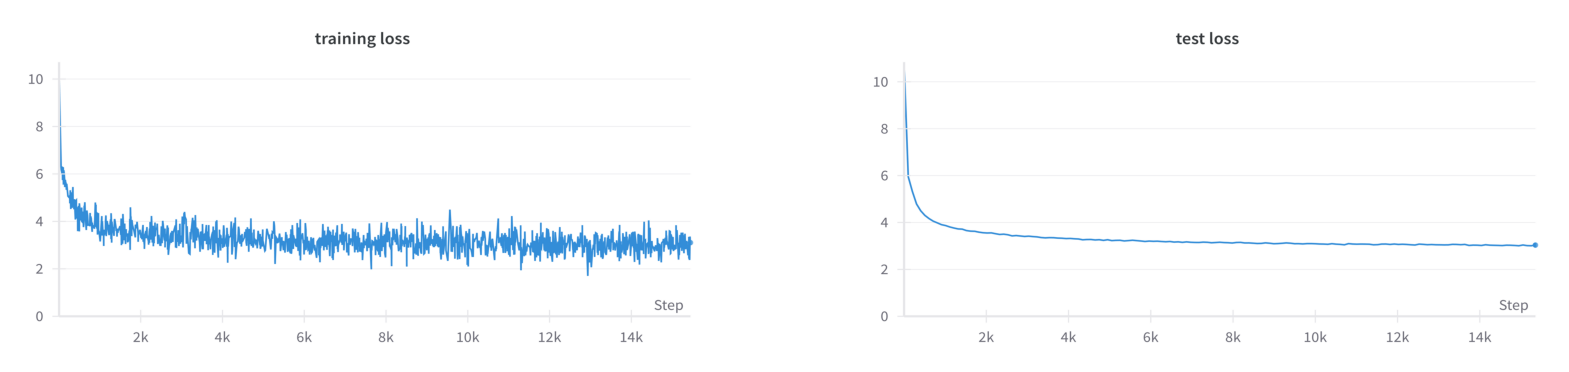

In [ ]:
from PIL import Image as PILImage
from IPython.display import display
import matplotlib.pyplot as plt

listOfImageNames = ['./Images/minigpt_tr_loss.png', './Images/minigpt_test_loss.png']

# Load and resize images
images = [PILImage.open(imageName).resize((1600, 800)) for imageName in listOfImageNames]  # Adjust the size as needed

# Display images side by side
fig, axes = plt.subplots(1, len(images), figsize=(20, 10))  # Adjust figsize as needed

for ax, img in zip(axes, images):
    ax.imshow(img)
    ax.axis('off')  # Hide axes

plt.show()

### Generation (5 points)


Perform generation with the model that you trained. Copy over the generation function you used for the Bigram model not the `miniGPT` class and generate a mini story using the same seed sentence.

    `"once upon a time"`

In [69]:
import os
from model import BigramLanguageModel, MiniGPT
from dataset import TinyStoriesDataset
from config import BigramConfig, MiniGPTConfig

config = MiniGPTConfig
config.context_length = 10
config.embed_dim = 64
config.num_heads = 4
config.num_layers = 1
model = MiniGPT(config)

tokenizer = tiktoken.get_encoding("gpt2")
nth_check_point = str(15) + 'save_iterations_checkpoint.pth'
load_path = os.path.join(config.save_path, nth_check_point)
checkpoint = torch.load(load_path)

# Extract the configuration, model state dict, and optimizer state dict
dmconfig = checkpoint['dmconfig']
model_state_dict = checkpoint['model_state_dict']
optimizer_state_dict = checkpoint['optimizer_state_dict']

# Load the model state dict
model.load_state_dict(model_state_dict)
model = model.to(device)

gen_sent = "Once upon a time"
gen_tokens = torch.tensor(tokenizer.encode(gen_sent))
print("Generating text starting with:", gen_tokens.shape)
gen_tokens = gen_tokens.to(device)
model.eval()
print(
    tokenizer.decode(
        model.generate(gen_tokens, max_new_tokens=200).squeeze().tolist()
    )
)

Generating text starting with: torch.Size([4])
Once upon a time, there was a little girl named Lily. She loved to wear her big bag of cups. The green teddy bear kept her head and a mild cake. Lily was a happy red pizza. She learned that being lost promised to talk to others and see the anchor. The deer was scared. Hes like the clever song. He did not want to share his things and not new things.Once upon a time, there was the best party ever Where was over the film and they think it made him feel sick. Lily realized that they were inside the school, you can without being a terrible plan.Tim and his mom learned that being competitive and not nice to help Ben.
Tom was so happy and thanked Bub ants for the new adventure.
Tim felt sorry and said, "We need to be good." 
Tom thought about what would try to eat it. Sam felt a sad toy. Bob had moving guitar every orange that flew high inside, so it started to get out!


Please answer the following questions.

1. What can we say about the generated text in terms of grammar and coherence?
2. If the model is scaled with more parameters do you expect the GPT model to get substantially better? Why or why not?

1. The grammar and coherence are better than that generated by bigram. But there are still some errors.
2. I expect it to get much better with more parameters and long training. Since the gpt model makes use of the attension mechanism, it is able to get better coherence by attending to previously generated text.

### Scaling up the model (5 points)

To show that scale indeed will help the model learn we have trained a scaled up version of the model you just implemented. We will load the weights of this model and generate a mini story using the same seed sentence. Note that if you have implemented the model correctly just scaling the parameters and adding a few bells and whistles to the training script will results in a model like the one we will load now.

In [55]:
from model import MiniGPT
from config import MiniGPTConfig

In [56]:
path_to_trained_model = "pretrained_models/best_train_loss_checkpoint.pth"

In [57]:
ckpt = torch.load(path_to_trained_model, map_location=device) # remove map location if using GPU

In [58]:
# Set the configs for scaled model
MiniGPTConfig.context_length = 512
MiniGPTConfig.embed_dim = 256
MiniGPTConfig.num_heads = 16
MiniGPTConfig.num_layers = 8

In [59]:
# Load model from checkpoint
model = MiniGPT(MiniGPTConfig)
model.load_state_dict(ckpt["model_state_dict"])

<All keys matched successfully>

In [60]:
tokenizer = tiktoken.get_encoding("gpt2")

In [62]:
model.to(device)
gen_sent = "Once upon a time"
gen_tokens = torch.tensor(tokenizer.encode(gen_sent))
print("Generating text starting with:", gen_tokens.shape)
gen_tokens = gen_tokens.to(device)
model.eval()
print(
    tokenizer.decode(
        model.generate(gen_tokens, max_new_tokens=200).squeeze().tolist()
    )
)

Generating text starting with: torch.Size([4])
Once upon a time, there was a little girl named Mia. She liked to read books. One day, Mia found a big book. It was very colorful. Mia was very happy. She opened the book and saw many wrote.
Mia opened the book and saw a book with many pictures. She read the book about animals. She liked the pictures of cats, dogs, and birds. She was very excited. Mia wanted to read the book later.
Mia put on her shoes again. She went back to the book. She started to read the book, like a family. But she was still worried. She read the small book slowly, and the book began to show her mom. Mia looked at the book every day.
But the next day, Mia heard a crab coming. She scared the crab away. The crab helped her read the story. Mia was very happy. She read home to her mom and dad when she got home, and they read the story together.One day,


## Bonus (5 points)

The following are some open ended questions that you can attempt if you have time. Feel free to propose your own as well if you have an interesting idea.

1. The model we have implemented is a decoder only model. Can you implement the encoder part as well? This should not be too hard to do since most of the layers are already implemented.
2. What are some improvements we can add to the training script to make training more efficient and faster? Can you concretely show that the improvements you made help in training the model better?
3. Can you implement a beam search decoder to generate the text instead of greedy decoding? Does this help in generating better text?
4. Can you further optimize the model architecture? For example, can you implement [Multi Query Attention](https://arxiv.org/abs/1911.02150) or [Grouped Query Attention](https://arxiv.org/pdf/2305.13245) to improve the model performance?